<a href="https://colab.research.google.com/github/zeegy99/backtester/blob/main/Efficient_Frontier_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Overarching Goal: Try to understand how cash flows into companies & why from large institutions.

Assumptions: These companies are stable, Universe is large ETF's to choose from.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import random

In [2]:
universe_list = ['SPY','QQQ', 'IWM', 'EFA', 'EEM', 'AGG', 'TIP', 'VNQ']
tickers = yf.download(universe_list, start="2015-01-01", end="2021-01-01")['Close']
returns = tickers.pct_change()
print(returns.head())
#Daily Pct Change


/tmp/ipython-input-3457790238.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  tickers = yf.download(universe_list, start="2015-01-01", end="2021-01-01")['Close']
[*********************100%***********************]  8 of 8 completed

Ticker           AGG       EEM       EFA       IWM       QQQ       SPY  \
Date                                                                     
2015-01-02       NaN       NaN       NaN       NaN       NaN       NaN   
2015-01-05  0.002173 -0.017797 -0.023605 -0.013369 -0.014669 -0.018060   
2015-01-06  0.002530 -0.004202 -0.011327 -0.017300 -0.013408 -0.009419   
2015-01-07 -0.000181  0.021625  0.011115  0.012315  0.012891  0.012461   
2015-01-08 -0.001532  0.017036  0.013530  0.016962  0.019139  0.017745   

Ticker           TIP       VNQ  
Date                            
2015-01-02       NaN       NaN  
2015-01-05  0.000798  0.005473  
2015-01-06  0.000088  0.009919  
2015-01-07  0.000797  0.015331  
2015-01-08 -0.001594  0.003775  


In [3]:
correlation = returns.corr()
mean_returns = returns.mean()
std = returns.std()


In [4]:
#Scraping for current rfr
import requests
from bs4 import BeautifulSoup

link = 'https://www.federalreserve.gov/releases/h15/'

bsobj = BeautifulSoup(requests.get(link).text, 'html.parser')

filtered = (bsobj.find_all('td', class_ = 'data'))
interest_rate = (filtered[89].get_text().strip())

print(interest_rate)


3.52


In [5]:
print(correlation.shape)
weights = []
for j in range(len(universe_list)):
    weights.append(random.uniform(0, 1))
weights = np.array(weights)
weights = weights/np.sum(weights)

print(weights.shape)
print(weights)

correlation = correlation.to_numpy()

(8, 8)
(8,)
[0.15568249 0.02124633 0.24622411 0.17358345 0.03104875 0.1732462
 0.01646634 0.18250233]


In [6]:
num_portfolios = 10000
results = np.zeros((3, num_portfolios))

for i in range(num_portfolios):
    weights = []
    for j in range(len(universe_list)):
        weights.append(random.uniform(0, 1))
    weights = np.array(weights)
    weights = weights/np.sum(weights)

    portfolio_return = np.dot(weights, mean_returns) * 252
    portfolio_vol = 0

    for a in range(len(universe_list)):
        for b in range(len(universe_list)):
          portfolio_vol += weights[a] * weights[b] * correlation[a][b]
    portfolio_vol = np.sqrt(portfolio_vol * 252)

    sharpe = (portfolio_return - (float(interest_rate) / 100))/ portfolio_vol

    results[0,i] = portfolio_vol
    results[1,i] = portfolio_return
    results[2,i] = sharpe

Returns are simple: We use the assumption that previous returns are 'stable'. We find the average daily return, then assume 252 days so multiply by that.

For Portfolio Volatility, we calculate by looking at $w_i \cdot w_j \cdot corr(a, b)$. For small portfolio's with small universes, we can $O(n^2)$ this with minimal computational constraints. There are probably more efficient ways to compute this since the matrix is symmetric.

In [21]:
print(results)

[[1.19170733e+01 1.13637862e+01 1.16545167e+01 ... 1.30146780e+01
  1.14859973e+01 1.03260867e+01]
 [1.03109268e-01 1.07571544e-01 1.07035031e-01 ... 1.07471345e-01
  9.84529763e-02 9.55504571e-02]
 [5.69848534e-03 6.36861186e-03 6.16370738e-03 ... 5.55306442e-03
  5.50696423e-03 5.84446546e-03]]


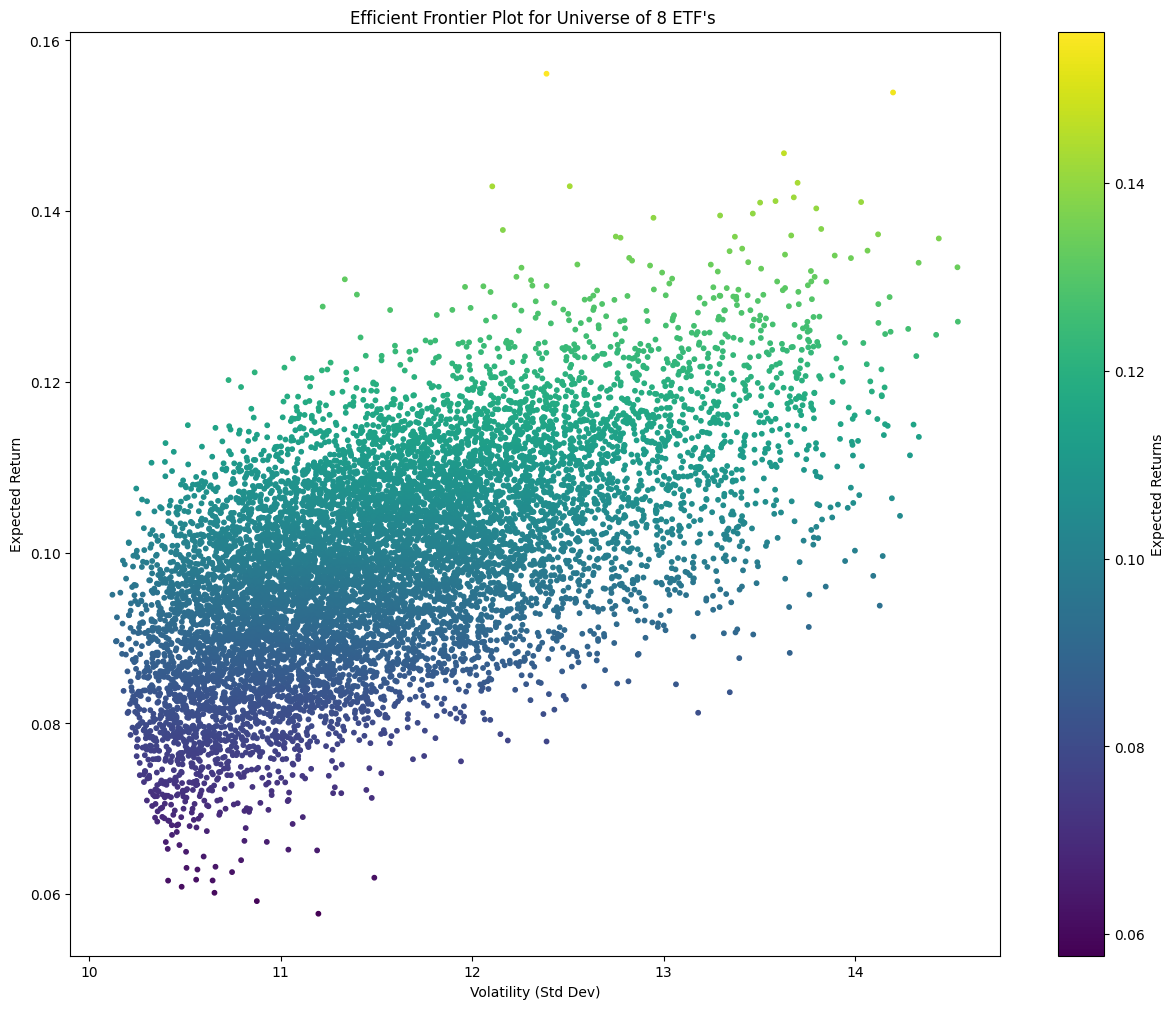

In [8]:
plt.figure(figsize=(15,12))
plt.scatter(results[0], results[1], c=results[1], cmap='viridis', marker='o', s=10)
plt.colorbar(label='Expected Returns')
plt.xlabel('Volatility (Std Dev)')
plt.ylabel('Expected Return')
plt.title("Efficient Frontier Plot for Universe of 8 ETF's ")
plt.show()


While there may be more efficient frontiers since we are doing this by chance, this is good enough.

In [9]:
vol = results[0]
expected_returns = results[1]

drawing_line = [(expected_returns[i], vol[i]) for i in range(len(vol))]
drawing_line.sort()

print(drawing_line[:5])




[(np.float64(0.05771893329768583), np.float64(11.196928898217058)), (np.float64(0.0591956794763505), np.float64(10.875364923269164)), (np.float64(0.06017160175316553), np.float64(10.65407238360922)), (np.float64(0.06087752818712125), np.float64(10.482707940178834)), (np.float64(0.06159613307167422), np.float64(10.411780132419551))]


Observation: Sorting by Returns is harder b/c in simulation we have a sparse dataset a.s. Thus, we must sort by volatility since for the lowest volatility, we can accept the return. Then, for higher volatility if the returns aren't as high, we will not accept those points. Compared to using epsilon balls or some K-means for sorting by returns, sorting by volatility is much simpler.

[(np.float64(0.05771893329768583), np.float64(11.196928898217058)), (np.float64(0.0591956794763505), np.float64(10.875364923269164)), (np.float64(0.06017160175316553), np.float64(10.65407238360922)), (np.float64(0.06087752818712125), np.float64(10.482707940178834)), (np.float64(0.06159613307167422), np.float64(10.411780132419551)), (np.float64(0.061708459238896896), np.float64(10.558460655020905)), (np.float64(0.06193787762186465), np.float64(11.489209242040651)), (np.float64(0.06259426222331023), np.float64(10.745940459738735)), (np.float64(0.06289265973155364), np.float64(10.565164867155802)), (np.float64(0.06309102282512478), np.float64(10.508074712846659)), (np.float64(0.06322125132303656), np.float64(10.659346435789057)), (np.float64(0.06399098095077219), np.float64(10.793284200804187)), (np.float64(0.06441835681399204), np.float64(10.59760715604824)), (np.float64(0.06497216352447839), np.float64(10.505684325620475)), (np.float64(0.06513576520502713), np.float64(11.190359458011386

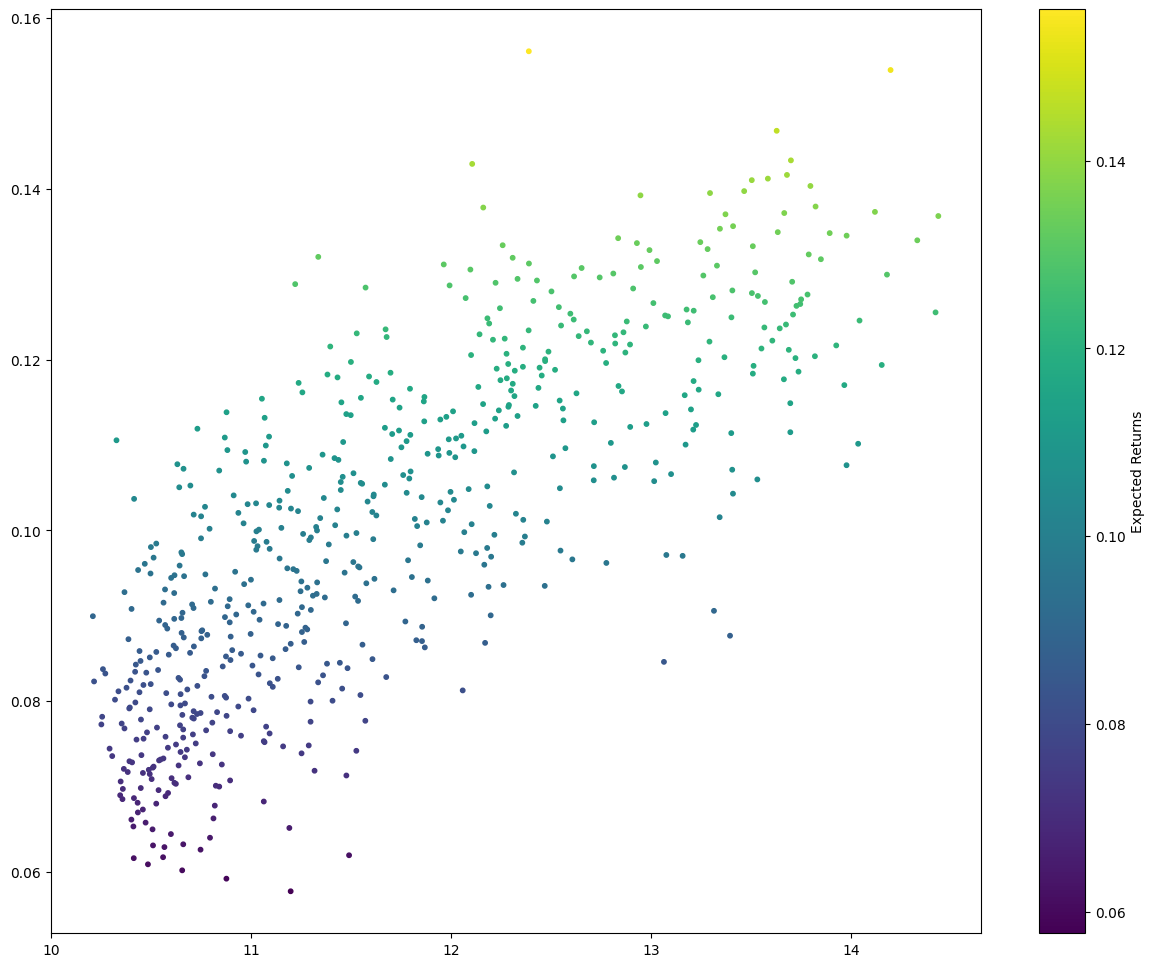

In [13]:
'''Unsuccessful attempt to sort by returns'''
similarity = 0.0001
init = 0
l = 0
added = []
for j in range(len(drawing_line)):
  if (drawing_line[j][0] - similarity) > init:
    added.append(drawing_line[j])
    init = drawing_line[j][0]
plt.figure(figsize=(15,12))
print(added)
x_axis = []
y_axis = []
for i in range(len(added)):
  x_axis.append(added[i][1])
  y_axis.append(added[i][0])
plt.scatter(x_axis, y_axis, c=y_axis, cmap='viridis', marker='o', s=10)
plt.colorbar(label='Expected Returns')

[(np.float64(0.0950834544431647), np.float64(10.121002856951085)), (np.float64(0.08961828238516757), np.float64(10.139427427673791)), (np.float64(0.08966105472984101), np.float64(10.14279494846978)), (np.float64(0.0924380845870472), np.float64(10.144594990325658)), (np.float64(0.0953218434801472), np.float64(10.162407396323369)), (np.float64(0.08922492417142745), np.float64(10.168971545752498)), (np.float64(0.08815583901419512), np.float64(10.171312237595954)), (np.float64(0.09170246789838626), np.float64(10.17399432391266)), (np.float64(0.09907941944581639), np.float64(10.175903227301342)), (np.float64(0.08381959077388386), np.float64(10.179333605132761)), (np.float64(0.09863913782064625), np.float64(10.185422828410072)), (np.float64(0.08806959346365516), np.float64(10.19141960337832)), (np.float64(0.09696802367308273), np.float64(10.192308402460172)), (np.float64(0.08610339811490936), np.float64(10.199603114545088)), (np.float64(0.08122537488704575), np.float64(10.20004211485876)), (

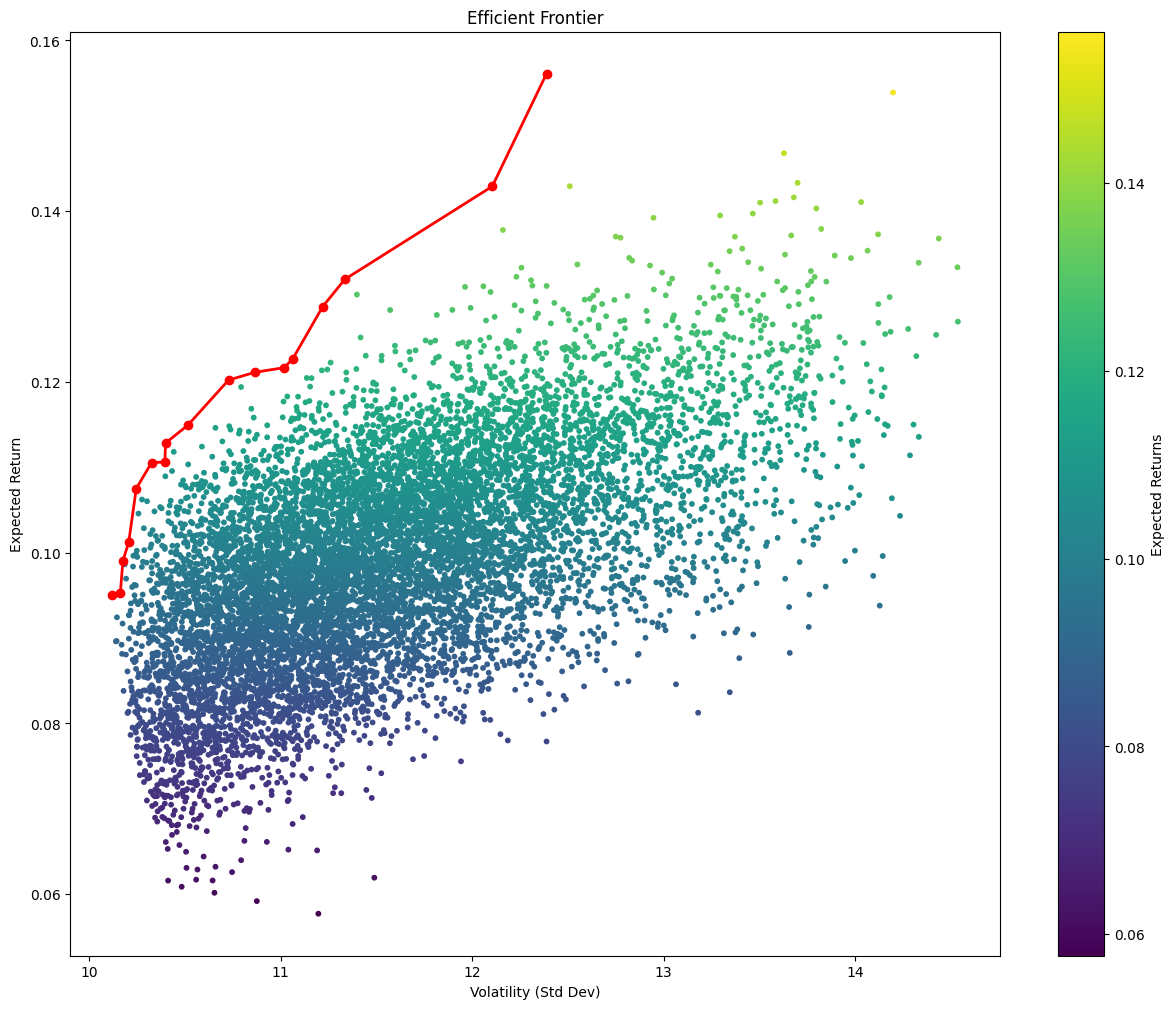

In [17]:
'''Successfully sorted by volatility'''
drawing_line_sorted = sorted(drawing_line, key=lambda x: x[1])  # x[1] = vol
print(drawing_line_sorted[:20])
ef_points = []
max_ret_so_far = -100

for ret, vol in drawing_line_sorted:
    if ret > max_ret_so_far:
        ef_points.append((ret, vol))
        max_ret_so_far = ret

# 3. Separate x/y for plotting
x_axis = [p[1] for p in ef_points]   # vol
y_axis = [p[0] for p in ef_points]   # ret

plt.figure(figsize=(15, 12))

all_x = [p[1] for p in drawing_line]
all_y = [p[0] for p in drawing_line]
plt.scatter(all_x, all_y, c = all_y, cmap = 'viridis', marker = 'o', s = 10)
plt.colorbar(label='Expected Returns')

# Plot the efficient frontier line
plt.plot(x_axis, y_axis, linewidth=2, marker='o', color='r')

plt.xlabel("Volatility (Std Dev)")
plt.ylabel("Expected Return")
plt.title("Efficient Frontier")
plt.show()


Out of our efficient frontier, we want to choose the highest sharpe out of these options.

In [23]:
rfr = float(interest_rate) / 100
max_sharpe = -np.inf

for ret, vol in ef_points:
  # print("I am vol", vol, "I am ret", ret)
  sharpe = (ret - rfr) / vol
  if sharpe > max_sharpe:
      max_sharpe = sharpe
      max_ret = ret
      max_vol = vol

print("Max Sharpe Ratio:", max_sharpe)
print("Max Return:", max_ret)
print("Max Volatility:", max_vol)

Max Sharpe Ratio: 0.009759409687065445
Max Return: 0.15610695972313415
Max Volatility: 12.388757476118377


In [25]:
print(x_axis, y_axis, float(interest_rate) / 100)

[np.float64(10.121002856951085), np.float64(10.162407396323369), np.float64(10.175903227301342), np.float64(10.206024978466278), np.float64(10.245507882561958), np.float64(10.325271174887105), np.float64(10.395250871916797), np.float64(10.398310039439139), np.float64(10.515054360473874), np.float64(10.727647106297011), np.float64(10.864126639743777), np.float64(11.019618296545048), np.float64(11.064040739560257), np.float64(11.21958876973785), np.float64(11.335080084192185), np.float64(12.10538650366129), np.float64(12.388757476118377)] [np.float64(0.0950834544431647), np.float64(0.0953218434801472), np.float64(0.09907941944581639), np.float64(0.10121302402087833), np.float64(0.10751984103054234), np.float64(0.11054248754977122), np.float64(0.11063601446794606), np.float64(0.11284496676856627), np.float64(0.11494388865257166), np.float64(0.12022457308346397), np.float64(0.12112821498130091), np.float64(0.12168410862659922), np.float64(0.12275003728071204), np.float64(0.1288329901829634

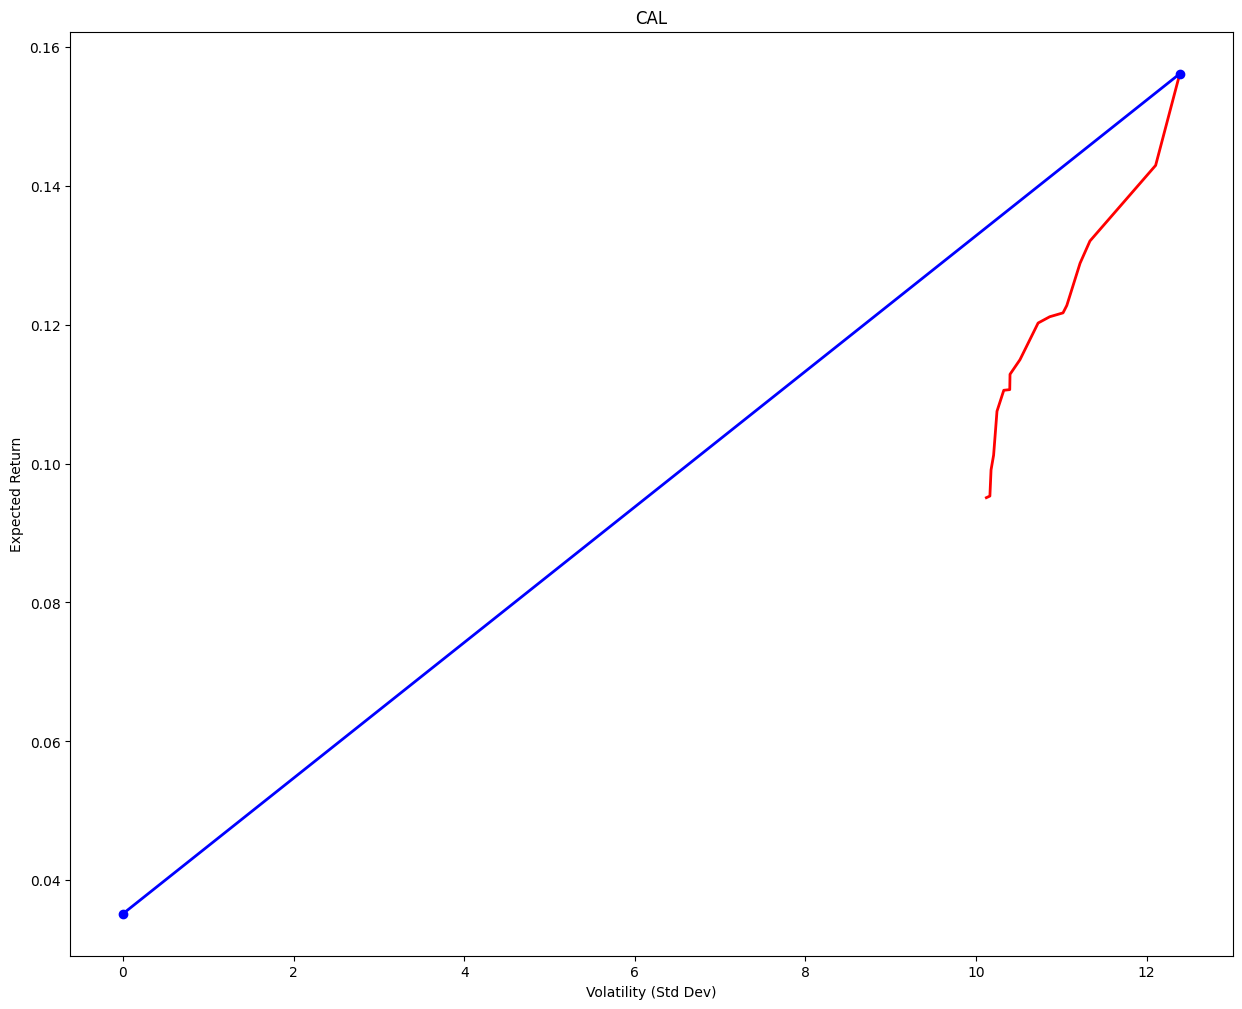

In [31]:
plt.figure(figsize=(15,12))
x_axis_plot = [0, max_vol]
y_axis_plot = [rfr, max_ret]
plt.plot(x_axis, y_axis, linewidth=2, markersize=4, color='r')
plt.plot(x_axis_plot, y_axis_plot, linewidth=2, marker='o', color='b')
plt.xlabel("Volatility (Std Dev)")
plt.ylabel("Expected Return")
plt.title("CAL")
plt.legend
plt.show()